In [1]:
from model import get_model
import yaml
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from dataset import get_dataset
import cv2
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    type_device = "cuda"
    nb_device = torch.cuda.device_count()
else:
    type_device = "cpu"
    nb_device = None
device = torch.device(type_device)

In [5]:
config_path = "../runs/mnist/0627_mnist/mnist.yml"
model_ckpt_path = "../runs/mnist/0627_mnist/model.pkl"

In [6]:
with open(config_path) as fp:
    cfg = yaml.load(fp, Loader=yaml.FullLoader)

In [7]:
# Datasets and dataloaders
dataset_kwargs = cfg["dataset"]
dataset_name = dataset_kwargs.pop("name")
train_dataset = get_dataset(dataset_name)("train", **dataset_kwargs)
val_dataset = get_dataset(dataset_name)("val", **dataset_kwargs)
n_classes = train_dataset.n_classes
is_val_empty = len(val_dataset) == 0

img_size = train_dataset.img_size
batch_size = cfg["training"]["batch_size"]
n_workers = cfg["training"].get("n_workers", 4)
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                                num_workers=n_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=n_workers)

In [8]:
# Model
model_kwargs = cfg["model"]
model_name = model_kwargs.pop("name")
is_gmm = 'gmm' in model_name
model = get_model(model_name)(train_loader.dataset, **model_kwargs).to(device)

/home/HDD2/songkang/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/home/HDD2/songkang/.conda/envs/pytorch/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
checkpoint = torch.load(model_ckpt_path)
model.load_state_dict(checkpoint['model_state'])

In [10]:
img_paths = {
    "/home/HDD2/songkang/dti-clustering/runs/mnist/0627_mnist/transformations/img2/tsf9.png"
}

In [13]:
# 定义转换
transform = transforms.ToTensor()

def load_image(img_path, device):
    # 使用 OpenCV 读取图像
    img = cv2.imread(img_path)
    # 转换为 RGB
    # img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 将图像转换为 Tensor，并移动到指定设备
    img_tensor = transform(img_rgb).unsqueeze(0).to(device)
    return img_rgb, img_tensor

def show_image_and_cluster(img_rgb, cluster_index, is_grayscale=False):
    # 显示图像
    if is_grayscale:
        plt.imshow(img_rgb, cmap='gray')
    else:
        plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f'Cluster: {cluster_index}')
    plt.show()

def predict_cluster(model, img_tensor):
    # 获取距离矩阵
    distances = model(img_tensor)[1]
    # 找到最小距离的簇
    cluster_index = torch.argmin(distances, dim=1).item()
    return cluster_index

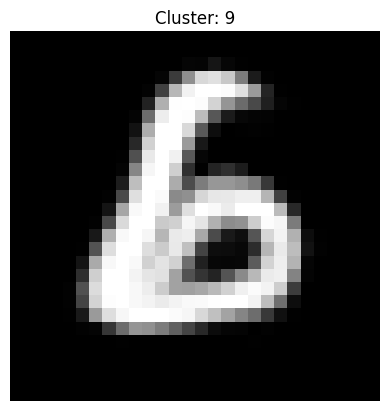

In [14]:
transform = transforms.ToTensor()
model.eval()
for img_path in img_paths:
    img_rgb, img_tensor = load_image(img_path, device)
    cluster_index = predict_cluster(model, img_tensor)
    show_image_and_cluster(img_rgb, cluster_index, True)